In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import matplotlib.pyplot as plt
import sqlite3

In [2]:
EXPERIMENT_DIR = '/data2/experiments/P3856'
# EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test'
MINIMUM_NUMBER_OF_RUNS = 5  # only looking at the 10 1to1 runs

In [3]:
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)

# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result

In [4]:
EXTRACTED_FEATURES_DIR = "{}/extracted-features".format(EXPERIMENT_DIR)
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features.sqlite".format(EXTRACTED_FEATURES_DIR)


#### look at sequences that appear in more half the runs in the experiment

In [5]:
subset_group = 'YHE114'

In [13]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query('select sequence,charge,file_idx,peak_idx,number_of_runs_extracted,human,run_name,intensity,isotope_idx_not_in_saturation,inferred from features where number_of_runs_extracted >= {} order by intensity desc'.format(MINIMUM_NUMBER_OF_RUNS), db_conn)
sequences_df.human = sequences_df.human.astype(bool)
sequences_df.inferred = sequences_df.inferred.astype(bool)
db_conn.close()


DatabaseError: Execution failed on sql 'select sequence,charge,file_idx,peak_idx,number_of_runs_extracted,human,run_name,intensity,isotope_idx_not_in_saturation,inferred from features where number_of_runs_extracted >= 5 order by intensity desc': no such column: number_of_runs_extracted

In [106]:
sequences_df['log_intensity'] = np.log2(sequences_df.intensity)

In [107]:
sequences_df[['sequence','charge','intensity','file_idx','human','number_of_runs_extracted','inferred']].sample(10).sort_values(by=['intensity','sequence','charge'], ascending=False, inplace=False)


,sequence,charge,intensity,file_idx,human,number_of_runs_extracted,inferred
12630,IHFPLATYAPVISAEK,2,12440,8,True,10,True
13468,AGKPVICATQMLESMIK,2,11752,6,True,10,True
36023,TDNAGDQHGGGGGGGGGAGAAGGGGGGENYDDPHK,4,5189,11,True,10,False
39227,SNLVDNTNQVEVLQR,2,4816,11,True,10,False
57010,VVHIMDFQR,2,3408,6,True,10,False
100921,SGVLDESTIATILR,2,1824,15,True,8,False
117172,ADFDNTVAIHPTSSEELVTLR,3,1497,16,True,10,False
154700,VTTASVASDGNLAITCSR,2,962,16,False,10,False
156058,VLLGFSSDESDVEASPR,2,946,16,True,9,False
209677,GAIILSSLLQSCDLEVANK,2,308,10,True,9,False


#### analyse a selected sequence across the experiment for runs in which it was classified as a target

In [108]:
selected_sequence = 'ELSDPAGAIIYTSR'
selected_sequence_charge = 2

In [109]:
selected_sequence_df = sequences_df[(sequences_df.sequence == selected_sequence) & (sequences_df.charge == selected_sequence_charge)].copy()
selected_sequence_df.sort_values(by=['run_name'], inplace=True)

#### compare the intensities across the experiment for the selected sequence

In [110]:
selected_sequence_1to1_df = selected_sequence_df[selected_sequence_df.batch == '1to1']

In [111]:
MAX_SUMMED_APEX_POINTS = 3 * 3000

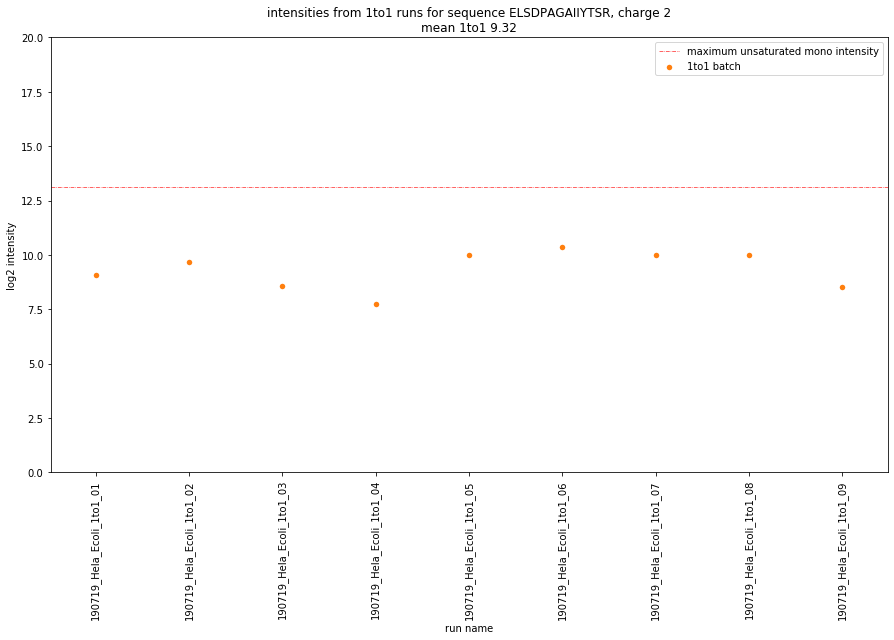

In [112]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

mean_1to1 = round(np.mean(np.log2(selected_sequence_1to1_df.intensity)), 2)

plt.title('intensities from 1to1 runs for sequence {}, charge {}\nmean 1to1 {}'.format(selected_sequence, selected_sequence_charge, mean_1to1))

ax1.scatter(selected_sequence_1to1_df.run_name, selected_sequence_1to1_df.log_intensity, marker='o', color='tab:orange', lw=0, s=30, alpha=1.0, label='1to1 batch')

# highlight whether a point was adjusted for saturation
adj_sat_1to1 = selected_sequence_1to1_df[(selected_sequence_1to1_df.isotope_idx_not_in_saturation > 0)]
if len(adj_sat_1to1) > 0:
    ax1.plot(adj_sat_1to1.run_name, adj_sat_1to1.log_intensity, marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15, label='inferred intensity')

# show which isotope was used as a reference
text_style = dict(size=10, color='blue')
for idx,row in adj_sat_1to1.iterrows():
    ax1.text(row.run_name, row.log_intensity+2.1, "ref iso {}".format(int(row.isotope_idx_not_in_saturation)), **text_style, rotation=90)

plt.axhline(y=np.log2(MAX_SUMMED_APEX_POINTS), color='red', linestyle='-.', linewidth=0.6, label='maximum unsaturated mono intensity')

plt.xlabel('run name')
plt.ylabel('log2 intensity')
plt.legend(loc='best')

# plt.xlim((0,50))
plt.ylim((0,20))
plt.xticks(rotation=90)

plt.show()

#### look at the distribution of intensity CV across the 1to1 runs

In [73]:
# find the intensity CV of each sequence in the 1to1 runs
sequence_intensity_cv_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    if len(group_df) >= 2:
        sequence = group_name[0]
        charge = group_name[1]
        sequence_intensity_cv = np.std(group_df.intensity) / np.mean(group_df.intensity)
        inferred = 
        sequence_intensity_cv_l.append((sequence,charge,sequence_intensity_cv))
sequence_intensity_cv_df = pd.DataFrame(sequence_intensity_cv_l, columns=['sequence','charge','intensity_cv'])


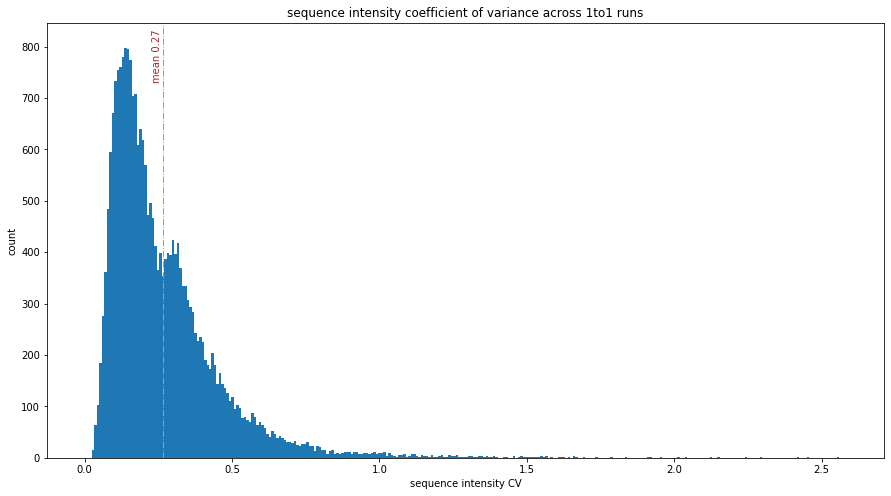

In [98]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = sequence_intensity_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('sequence intensity coefficient of variance across 1to1 runs')

plt.show()